## Plot mutation prediction results

Notebook parameters:
* SIG_ALPHA (float): significance cutoff (after FDR correction)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
# set results directory
results_dir = Path(cfg.results_dir, 'gene').resolve()
# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

In [3]:
# load raw data
results_df = au.load_stratified_prediction_results(results_dir, 'gene')
print(results_df.shape)
results_df.head()

(9492, 9)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.56379,0.165090,MAP3K1,expression,shuffled,42,train,0,gene
1,0.46135,0.086369,MAP3K1,expression,shuffled,42,test,0,gene
2,0.48896,0.069915,MAP3K1,expression,shuffled,42,cv,0,gene
3,0.50000,0.078323,MAP3K1,expression,shuffled,42,train,1,gene
4,0.50000,0.071259,MAP3K1,expression,shuffled,42,test,1,gene


In [4]:
expression_df = (
    results_df[results_df.training_data == 'expression']
        .drop(columns=['training_data'])
)
expression_results_df = au.compare_results(expression_df,
                                           identifier='identifier',
                                           metric='aupr',
                                           correction=True,
                                           correction_method='fdr_bh',
                                           correction_alpha=SIG_ALPHA,
                                           verbose=True)
expression_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
expression_results_df.sort_values(by='p_value').head(n=10)

shapes unequal for CBL, skipping
shapes unequal for CDC73, skipping
shapes unequal for HNF1A, skipping
shapes unequal for MLH1, skipping
shapes unequal for PTPN11, skipping


,gene,delta_mean,p_value,corr_pval,reject_null
15,BRAF,0.617245,1.121428e-19,1.087785e-17,True
25,CTNNB1,0.593111,3.305822e-18,1.301609e-16,True
28,EGFR,0.584966,4.025594e-18,1.301609e-16,True
72,PIK3CA,0.345058,5.853374e-18,1.419443e-16,True
5,ARID1A,0.424040,1.412938e-16,2.741100e-15,True
93,TP53,0.404853,3.483038e-16,5.630911e-15,True
3,APC,0.582659,8.595405e-16,1.191078e-14,True
54,KRAS,0.474406,1.442342e-15,1.748840e-14,True
22,CIC,0.545687,7.647812e-15,8.242642e-14,True
30,ERBB2,0.571202,1.846692e-14,1.791291e-13,True


In [5]:
methylation_df = (
    results_df[results_df.training_data == 'methylation']
        .drop(columns=['training_data'])
)
methylation_results_df = au.compare_results(methylation_df,
                                            identifier='identifier',
                                            metric='aupr',
                                            correction=True,
                                            correction_method='fdr_bh',
                                            correction_alpha=SIG_ALPHA,
                                            verbose=True)
methylation_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
methylation_results_df.sort_values(by='p_value').head(n=10)

shapes unequal for CBL, skipping
shapes unequal for CDC73, skipping
shapes unequal for HIST1H3B, skipping
shapes unequal for PTPN11, skipping


,gene,delta_mean,p_value,corr_pval,reject_null
94,TP53,0.266487,3.410065e-17,3.341864e-15,True
3,APC,0.532541,1.014534e-16,4.971217e-15,True
15,BRAF,0.484979,6.861149e-15,2.241309e-13,True
46,IDH1,0.438526,3.573120e-14,8.754145e-13,True
28,EGFR,0.277732,4.820419e-13,9.448022e-12,True
54,KRAS,0.241381,2.722260e-11,4.446357e-10,True
21,CDKN2A,0.196310,3.906670e-11,5.469338e-10,True
69,NRAS,0.291291,6.223951e-11,7.624340e-10,True
5,ARID1A,0.290481,9.159015e-11,9.973150e-10,True
25,CTNNB1,0.342773,1.120363e-09,1.097955e-08,True


5

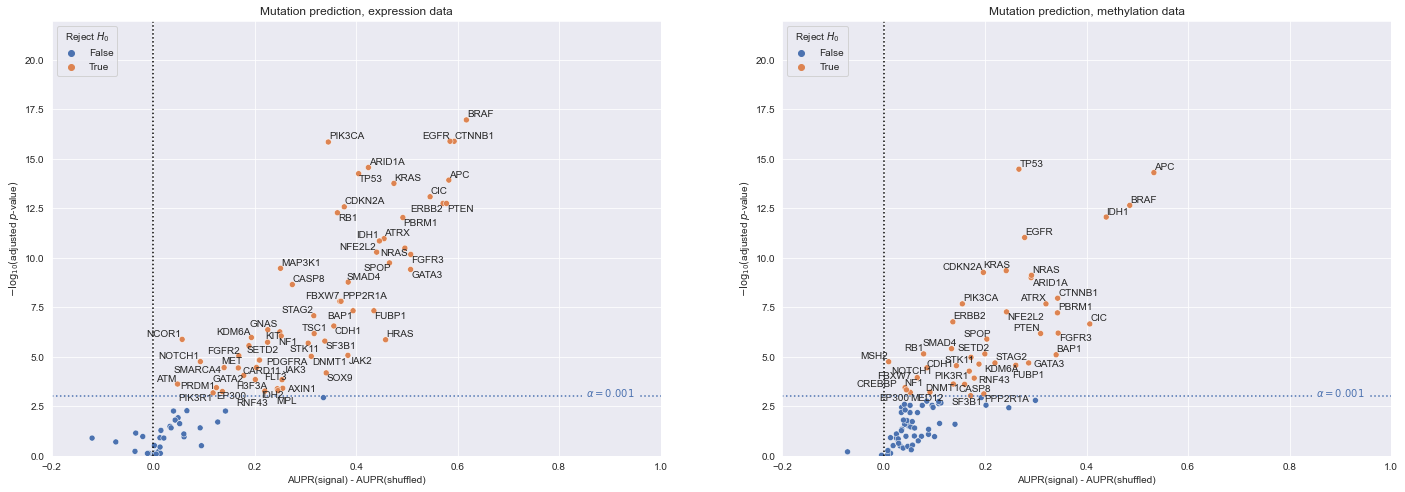

In [6]:
expression_results_df['nlog10_p'] = -np.log10(expression_results_df.corr_pval)
methylation_results_df['nlog10_p'] = -np.log10(methylation_results_df.corr_pval)

sns.set({'figure.figsize': (24, 8)})
fig, axarr = plt.subplots(1, 2)

# plot mutation prediction from expression, in a volcano-like plot
sns.scatterplot(data=expression_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                hue_order=[False, True], ax=axarr[0])
# add vertical line at 0
axarr[0].axvline(x=0, linestyle=':', color='black')
# add horizontal line at statistical significance threshold
l = axarr[0].axhline(y=-np.log10(SIG_ALPHA), linestyle=':')
# label horizontal line with significance threshold
# (matplotlib makes this fairly difficult, sadly)
axarr[0].text(0.9, -np.log10(SIG_ALPHA)+0.2,
              r'$\alpha = {}$'.format(SIG_ALPHA),
              va='center', ha='center', color=l.get_color(),
              backgroundcolor=axarr[0].get_facecolor())
axarr[0].set_xlabel('AUPR(signal) - AUPR(shuffled)')
axarr[0].set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
axarr[0].set_xlim((-0.2, 1.0))
y_max = max(expression_results_df.nlog10_p.max(), methylation_results_df.nlog10_p.max())
axarr[0].set_ylim((0, y_max+5))
axarr[0].legend(title=r'Reject $H_0$', loc='upper left')
axarr[0].set_title(r'Mutation prediction, expression data')

# plot mutation prediction from methylation, same as above
sns.scatterplot(data=methylation_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                hue_order=[False, True], ax=axarr[1])
axarr[1].axvline(x=0, linestyle=':', color='black')
l = axarr[1].axhline(y=-np.log10(SIG_ALPHA), linestyle=':')
axarr[1].text(0.9, -np.log10(SIG_ALPHA)+0.2,
              r'$\alpha = {}$'.format(SIG_ALPHA),
              va='center', ha='center', color=l.get_color(),
              backgroundcolor=axarr[0].get_facecolor())
axarr[1].set_xlabel('AUPR(signal) - AUPR(shuffled)')
axarr[1].set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
axarr[1].set_xlim((-0.2, 1.0))
axarr[1].set_ylim((0, y_max+5))
axarr[1].legend(title=r'Reject $H_0$', loc='upper left')
axarr[1].set_title(r'Mutation prediction, methylation data')

def label_points(x, y, gene, sig, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene, 'sig': sig})
    for i, point in a.iterrows():
        if point['y'] > -np.log10(SIG_ALPHA):
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

# label genes and adjust text to not overlap
# automatic alignment isn't perfect, can align by hand in inkscape if necessary
text_labels_expression = label_points(expression_results_df['delta_mean'],
                                      expression_results_df['nlog10_p'],
                                      expression_results_df.gene,
                                      expression_results_df.reject_null,
                                      axarr[0])
adjust_text(text_labels_expression,
            ax=axarr[0], 
            expand_text=(1., 1.),
            lim=5)

text_labels_methylation = label_points(methylation_results_df['delta_mean'],
                                       methylation_results_df['nlog10_p'],
                                       methylation_results_df.gene,
                                       methylation_results_df.reject_null,
                                       axarr[1])
adjust_text(text_labels_methylation,
            ax=axarr[1],
            expand_text=(1., 1.),
            lim=5)

In [7]:
compare_results_df = au.compare_results(methylation_df,
                                        pancancer_df=expression_df,
                                        identifier='identifier',
                                        metric='aupr',
                                        correction=True,
                                        correction_method='fdr_bh',
                                        correction_alpha=SIG_ALPHA,
                                        verbose=True)
compare_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
compare_results_df.head()

,gene,delta_mean,p_value,corr_pval,reject_null
0,BRCA1,-0.068334,1.150059e-01,1.892033e-01,False
1,PDGFRA,0.204356,1.101836e-05,5.619363e-05,True
2,CBL,0.009051,5.188763e-01,6.154114e-01,False
3,TP53,0.141596,1.764744e-13,1.800039e-11,True
4,CIC,0.144482,2.846070e-03,7.639450e-03,False


5

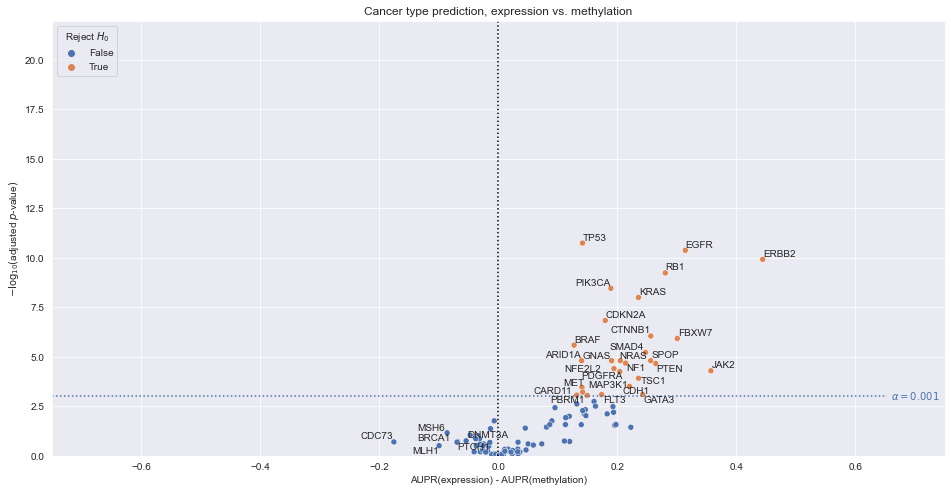

In [8]:
compare_results_df['nlog10_p'] = -np.log10(compare_results_df.corr_pval)

sns.set({'figure.figsize': (16, 8)})
sns.scatterplot(data=compare_results_df, x='delta_mean', y='nlog10_p', hue='reject_null')
plt.axvline(x=0, linestyle=':', color='black')
l = plt.axhline(y=-np.log10(SIG_ALPHA), linestyle=':')
plt.text(0.7, -np.log10(SIG_ALPHA)+0.05,
         r'$\alpha = {}$'.format(SIG_ALPHA),
         va='center', ha='center', color=l.get_color(),
         backgroundcolor=plt.gca().get_facecolor())
plt.xlabel('AUPR(expression) - AUPR(methylation)')
plt.ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
plt.xlim((-0.75, 0.75))
plt.ylim((0, y_max+5))
plt.legend(title=r'Reject $H_0$', loc='upper left')
plt.title(r'Cancer type prediction, expression vs. methylation')

def label_points(x, y, gene, sig, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene, 'sig': sig})
    for i, point in a.iterrows():
        if point['y'] > -np.log10(0.001):
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
        elif point['x'] < -0.05:
            # align these left, otherwise can't read
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']),
                        ha='right', va='bottom')
            )
    return text_labels

text_labels = label_points(compare_results_df['delta_mean'],
                           compare_results_df['nlog10_p'],
                           compare_results_df.gene,
                           compare_results_df.reject_null,
                           plt.gca())
adjust_text(text_labels,
            ax=plt.gca(),
            expand_text=(1., 1.),
            lim=5)

## Confusion matrix

In [31]:
import os

import mpmp.utilities.data_utilities as du

preds_dir = os.path.join(cfg.repo_root, 'results_preds', 'cancer_type')
sample_info_df = du.load_sample_info()

# TODO move to function
preds_df = pd.DataFrame()
for identifier in Path(preds_dir).iterdir():
    identifier_dir = Path(preds_dir, identifier)
    if identifier_dir.is_file():
        continue
    for results_file in identifier_dir.iterdir():
        if not results_file.is_file():
            continue
        results_filename = str(results_file.stem)
        if 'preds' not in results_filename:
            continue
        if 'signal' not in results_filename:
            continue
        # TODO document this (albeit functional) mess
        cancer_type_preds_df = (
            pd.read_csv(results_file, sep='\t', index_col=0)
              .merge(sample_info_df[['cancer_type']],
                     left_index=True, right_index=True)
              .drop(columns=['fold_no', 'true_class'])
              .groupby('cancer_type')
              .mean()
              .T
              .rename(index={'positive_prob': results_filename.split('_')[0]})
        )
        preds_df = pd.concat((preds_df, cancer_type_preds_df))
    
preds_df.sort_index(inplace=True)
print(preds_df.shape)
preds_df.head(n=20)

(33, 33)


cancer_type,ACC,BLCA,BRCA,CESC,CHOL,COAD,DLBC,ESCA,GBM,HNSC,...,READ,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM
ACC,0.936842,0.129160,0.139193,0.133552,0.143551,0.123186,0.135555,0.119602,0.138458,0.131233,...,0.123356,0.156360,0.121502,0.122092,0.174818,0.177126,0.170180,0.128165,0.141195,0.197901
BLCA,0.079862,0.847383,0.095647,0.404291,0.091285,0.088107,0.334478,0.161294,0.056977,0.299668,...,0.095938,0.194369,0.062885,0.085085,0.165681,0.063440,0.136652,0.097730,0.193116,0.086583
BRCA,0.030193,0.034806,0.907143,0.037347,0.020433,0.024451,0.039906,0.038028,0.023649,0.040722,...,0.023012,0.068985,0.032188,0.030475,0.052499,0.023383,0.036886,0.038641,0.049831,0.037454
CESC,0.087911,0.240968,0.110421,0.867470,0.112648,0.117367,0.215960,0.200114,0.065474,0.314727,...,0.114887,0.168958,0.051223,0.118636,0.239987,0.105883,0.226121,0.138311,0.228470,0.101009
CHOL,0.048104,0.062890,0.044219,0.060519,0.736422,0.065101,0.169097,0.062984,0.038444,0.052689,...,0.062608,0.067375,0.055361,0.086896,0.053875,0.066456,0.147639,0.053092,0.046068,0.044417
COAD,0.164130,0.121721,0.149898,0.173678,0.229484,0.927692,0.125284,0.271802,0.137045,0.136040,...,0.935949,0.155386,0.085548,0.380742,0.241620,0.185275,0.208051,0.155116,0.157742,0.185558
DLBC,0.022375,0.033088,0.029474,0.027617,0.053832,0.029056,0.960770,0.026340,0.026181,0.030191,...,0.028633,0.035272,0.048401,0.038610,0.044646,0.027824,0.073497,0.024022,0.024250,0.027467
ESCA,0.003299,0.036959,0.041149,0.063922,0.011623,0.046242,0.013047,0.855397,0.006414,0.177505,...,0.055161,0.012946,0.021646,0.466133,0.054512,0.009520,0.008349,0.018321,0.012085,0.003840
GBM,0.103019,0.076600,0.096025,0.073535,0.080182,0.080731,0.070919,0.075232,0.887711,0.075051,...,0.082294,0.205131,0.137093,0.085687,0.110392,0.091647,0.082829,0.087029,0.149214,0.080043
HNSC,0.000870,0.052440,0.002429,0.177729,0.001493,0.002782,0.003876,0.214184,0.001595,0.920148,...,0.003307,0.048303,0.003380,0.009448,0.004526,0.000884,0.009309,0.002500,0.004073,0.003325


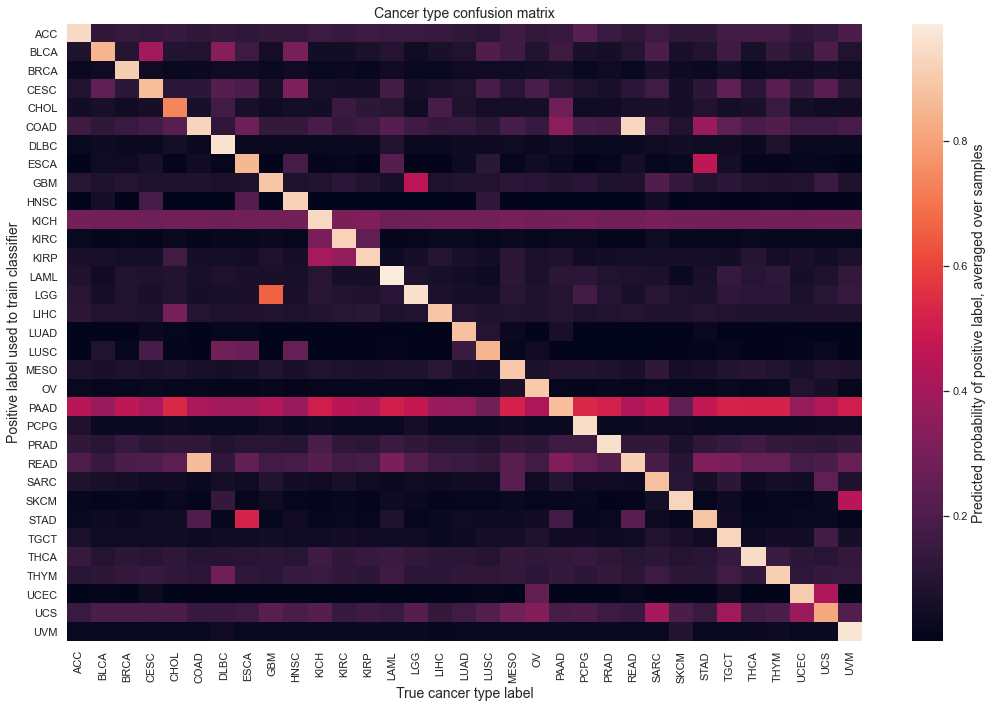

In [55]:
sns.set({'figure.figsize': (15, 10)})
ax = sns.heatmap(preds_df, cbar_kws={'label': 'Predicted probability of positive label, averaged over samples'})
# https://stackoverflow.com/a/48587137
ax.figure.axes[-1].yaxis.label.set_size(14)
plt.xlabel('True cancer type label', size=14)
plt.ylabel('Positive label used to train classifier', size=14)
plt.title('Cancer type confusion matrix', size=14)
plt.tight_layout()